In [2]:
import gym
import numpy as np
import random

env_name = "MountainCar-v0"
env = gym.make(env_name)

obs = env.reset()
#env.render()
n_states   = 40
episodes   = 10000
initial_lr = 1.0
min_lr     = 0.005
gamma      = 0.99
max_stps   = 300
epsilon    = 0.1

env = env.unwrapped
env.seed()
np.random.seed(0)

def discretization(env, obs):
    env_low    = env.observation_space.low
    env_high   = env.observation_space.high
    env_den    = (env_high - env_low) / n_states
    pos_den    = env_den[0]
    vel_den    = env_den[1]
    pos_high   = env_high[0]
    pos_low    = env_low[0]
    vel_high   = env_high[1]
    vel_low    = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

random.seed(7)
#  27 and 39
first_index = random.randint(15, n_states - 1)
second_index = random.randint(15, n_states - 1)
action_values = []
# 40 x 40 x 3 = 4800 possible options
q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0
for episode in range(episodes):
    #print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        #env.render()
        pos, vel = discretization(env, obs)
        
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)

        else:
            a = np.argmax(q_table[pos][vel])
            
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        
        pos_, vel_ = discretization(env, obs)
        
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a]+ alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        
        
        steps += 1
        if terminate:
            break
            
    action_values.append((q_table[first_index][second_index][0], q_table[first_index][second_index][1], q_table[first_index][second_index][2]))
#     action_values.append((q_table[20][20][0], q_table[20][20][1], q_table[20][20][2]))
#     if episode % 100 == 0:
#       print("results for q_table[20][20][0]")
#       print(q_table[20, 20, 0])
#       print(q_table[20][20][0])
#       print(action_values[episode])
print("FINISHED")
            
#while True:
#    env.render()

FINISHED


In [0]:
print(q_table[9][38])
print(pos)

[0. 0. 0.]
37


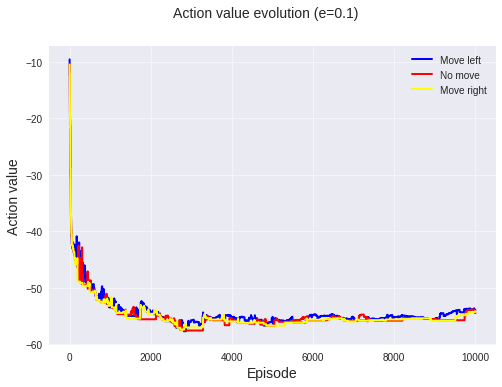

In [2]:
import matplotlib.pyplot as plt

array = np.arange(episodes)
# fig_3 = plt.figure(figsize=(4,4))
plt.suptitle("Action value evolution (e={})".format(epsilon), fontsize=14)
plt.ylabel('Action value', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.grid(linestyle='-', linewidth=0.5)
plt.plot(array, list(zip(*action_values))[0], color = "blue", label="Move left", linestyle='-', lw=2)
plt.plot(array, list(zip(*action_values))[1], color = "red", label="No move", linestyle='-', lw=2)
plt.plot(array, list(zip(*action_values))[2], color = "yellow", label="Move right", linestyle='-', lw=2)
plt.legend() 
plt.show()


40


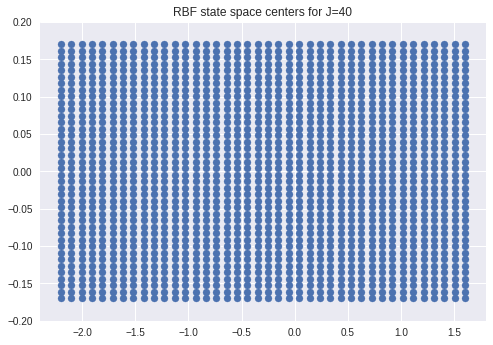

U: (1600, 1600)


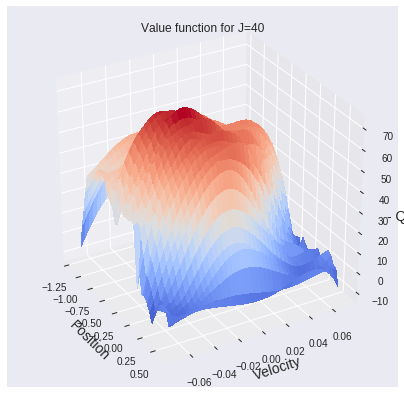

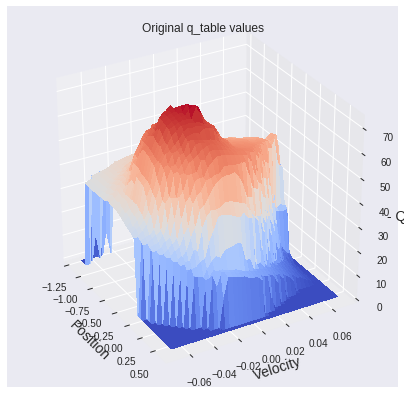

In [10]:
import matplotlib.pyplot as plt

def get_means(xaxes, yaxes, means_no):
  print(len(xaxes))
  xaxes_indices = np.linspace(np.min(xaxes)-1, np.max(xaxes)+1, means_no)
  yaxes_indices = np.linspace(np.min(yaxes)-0.1, np.max(yaxes)+0.1, means_no)
  xaxes_indices, yaxes_indices = np.meshgrid(xaxes_indices, yaxes_indices)
  return xaxes_indices, yaxes_indices


pos = np.linspace(-1.2, 0.6, 40)
vel = np.linspace(-0.07, 0.07, 40)
J = 40
actions = 3
N = len(pos) * len(vel)
features = 2
# Finding the means of pos * vel
pos_grid, vel_grid = np.meshgrid(pos, vel)
concat = np.dstack((pos_grid, vel_grid))
X = concat.reshape(N, features)

pointsx, pointsy = get_means(pos, vel, J)
concat = np.dstack((pointsx, pointsy))
means = concat.reshape(J*J, features)
plt.title("RBF state space centers for J={}".format(J))
plt.scatter(pointsx, pointsy)
plt.show()

def featurizer(pos, vel, J, means):
  N = len(pos) * len(vel)
  pos_grid, vel_grid = np.meshgrid(pos, vel)
  concat = np.dstack((pos_grid, vel_grid))
  X = concat.reshape(N, features)
# Constructing design matrix
  U = np.zeros((N, J**2))
  for i in range(N):
      for j in range(J**2):
  #       U[i][j] = np.exp(-np.linalg.norm(X[i] - means[j]) / (np.std(means[j])) ** 2 ) 
          U[i][j] = np.exp(-np.linalg.norm(X[i] - means[j])**2 / (2*np.std(means[j])**2) ) 
  return U

U = featurizer(pos, vel, J, means)
print('U:', U.shape)

# Calculating the optimal weights for the thre actions
w_action = np.dot((np.linalg.pinv(np.dot(U.T, U))), U.T) @ q_table.reshape(1600, 3)
yh_rbf = np.dot(U, w_action)


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter#    env.render()

# Plotting obtained value function
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

Z = yh_rbf.reshape(40, 40, 3)
Z = np.max(Z, 2)
# Y = np.linspace(-1.2, 0.6, 40)
# X = np.linspace(-0.07, 0.07, 40)
# X,Y = np.meshgrid(X,Y)
surf = ax.plot_surface(pos_grid, vel_grid, -Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('Value function for J={}'.format(J))
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.set_zlabel('- Q*', fontsize=14)
ax.view_init(30,-30)

# Plotting original Q_table
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
Z = np.max(q_table, 2)
surf = ax.plot_surface(pos_grid, vel_grid, -Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('Original q_table values')
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.set_zlabel('- Q*', fontsize=14)
ax.view_init(30,-30)

In [0]:

env_name = "MountainCar-v0"
env = gym.make(env_name)

obs = env.reset()
#env.render()
n_states   = 40
episodes   = 10000
initial_lr = 1.0
min_lr     = 0.005
gamma      = 0.99
max_stps   = 300
epsilon    = 0.2

env = env.unwrapped
env.seed()
np.random.seed(0)

# random.seed(7)
#  27 and 39
first_index = random.randint(15, n_states - 1)
second_index = random.randint(15, n_states - 1)
action_values = []
# 40 x 40 x 3 = 4800 possible options
total_steps = 0
for episode in range(episodes):
    #print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        #env.render()
        pos, vel = obs
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
             a = np.argmax(featurizer(np.array([pos]), np.array([vel]), J, means) @ w_action)
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        print(pos)
#         pos_, vel_ = discretization(env, obs)
        steps += 1
        if terminate:
            break
            
    action_values.append((q_table[first_index][second_index][0], q_table[first_index][second_index][1], q_table[first_index][second_index][2]))
print("FINISHED")        
#while True:
#    env.render()

NameError: ignored